In [6]:
import numpy as np  # Pour les opérations sur les tableaux
from scipy.stats import ttest_ind  # Pour effectuer le test de Welch t-test
import matplotlib.pyplot as plt  # Pour la génération de graphiques
import json

In [3]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [4]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

In [175]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )
    
    # plot
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    # plt.savefig(
    #     f"./statistical_tests/{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    # )
    # plt.show()

In [7]:
# Fonction pour charger un fichier JSON
def load_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

res_implementation_seed1 = load_json(file_path = "imple_training_results_seed1.json")
res_sb_seed1 = load_json(file_path = "sb_training_results_seed1.json")

# Récupération des données

In [125]:
import os
import re

def get_training_results_files_json(folder_path):
    # Définir le motif regex pour les fichiers de type "training_results_seed{num_seed}"
    pattern = re.compile(r"^training_results_seed(\d+).json$")
    
    # Obtenir la liste des fichiers dans le dossier
    files = os.listdir(folder_path)
    
    # Filtrer et extraire les numéros de seed
    training_results_files = [file for file in files if pattern.match(file)]
    
    # Trier les fichiers en fonction du numéro de seed
    training_results_files.sort(key=lambda x: int(pattern.match(x).group(1)))

    # Récupérer les données
    training_results_files_json = [load_json(f"{folder_path}/{filename}") for filename in training_results_files]
    
    return training_results_files_json

In [126]:
training_results_files_implementation=get_training_results_files_json("results_implementation")
training_results_files_stablebaseline=get_training_results_files_json("results_stablebaseline")

In [103]:
len(training_results_files_implementation) # Number of runs (one different seed per run)

5

In [104]:
len(training_results_files_stablebaseline) # Number of runs (one different seed per run)

5

In [124]:
def save_every_nth_step(steps_list, n=1000):
    """
    Modifie une liste de steps en sauvegardant les valeurs avec des pas de n et
    remplaçant les autres par une valeur par défaut.
    
    :param steps_list: (list) liste des steps d'origine
    :param n: (int) pas pour sauvegarder les valeurs (1000 par défaut)
    :return: (list) nouvelle liste avec valeurs sauvegardées tous les n steps
    """
    modified_list = [
        steps_list[i] if i % n == 0 else None
        for i in range(len(steps_list))
    ]
    # Supprimer tous les None de la liste
    modified_list = [step for step in modified_list if step is not None]
    return modified_list[1:]

In [127]:
# Sauvgarder les valeurs chaque mise a jour (chaque 1000 steps (valeurs))
for i in range(len(training_results_files_stablebaseline)):
    training_results_files_stablebaseline[i]['critic_losses']= save_every_nth_step(training_results_files_stablebaseline[i]['critic_losses'], n=1000) 
    training_results_files_stablebaseline[i]['actor_losses']= save_every_nth_step(training_results_files_stablebaseline[i]['actor_losses'], n=1000) 
    training_results_files_stablebaseline[i]['rewards_per_step']= save_every_nth_step(training_results_files_stablebaseline[i]['rewards_per_step'], n=1000) 

In [275]:
def plot_all(training_results_files_stablebaseline):
    # Création des steps multipliés par 1000 (on suppose que tous les fichiers ont la même longueur)
    num_files = len(training_results_files_stablebaseline)
    steps = list(range(len(training_results_files_stablebaseline[0]['actor_losses'])))  # Assumes same length for all files
    steps = [x * 1000 for x in steps]
    
    # Plot pour Actor Losses
    plt.figure(figsize=(12, 6))
    for i in range(num_files):
        plt.plot(steps, training_results_files_stablebaseline[i]['actor_losses'], label=f"seed={i+1}")
    plt.title("Actor Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Plot pour Critic Losses
    plt.figure(figsize=(12, 6))
    for i in range(num_files):
        plt.plot(steps, training_results_files_stablebaseline[i]['critic_losses'], label=f"seed={i+1}")
    plt.title("Critic Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot pour les Rewards
    plt.figure(figsize=(12, 6))
    for i in range(num_files):
        plt.plot(steps, training_results_files_stablebaseline[i]['rewards_per_step'], label=f"seed={i+1}")
    plt.title("Avg Reward")
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.show()

# Les courbes de l'entrainement avec stable_baseline3

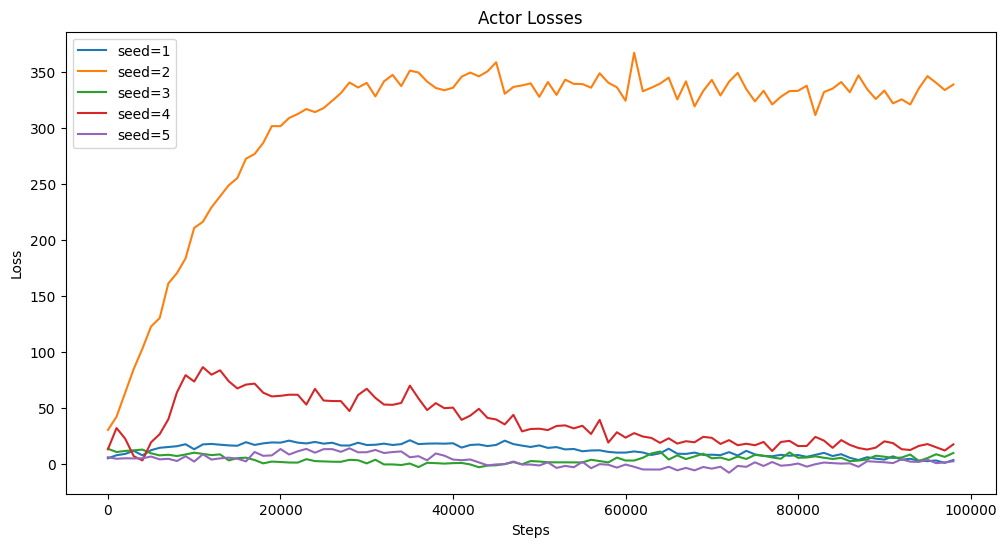

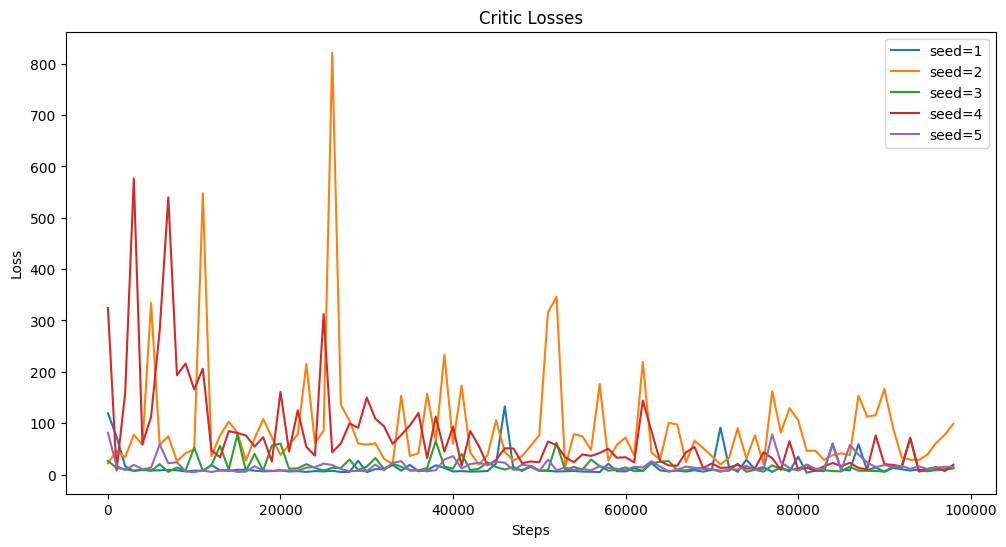

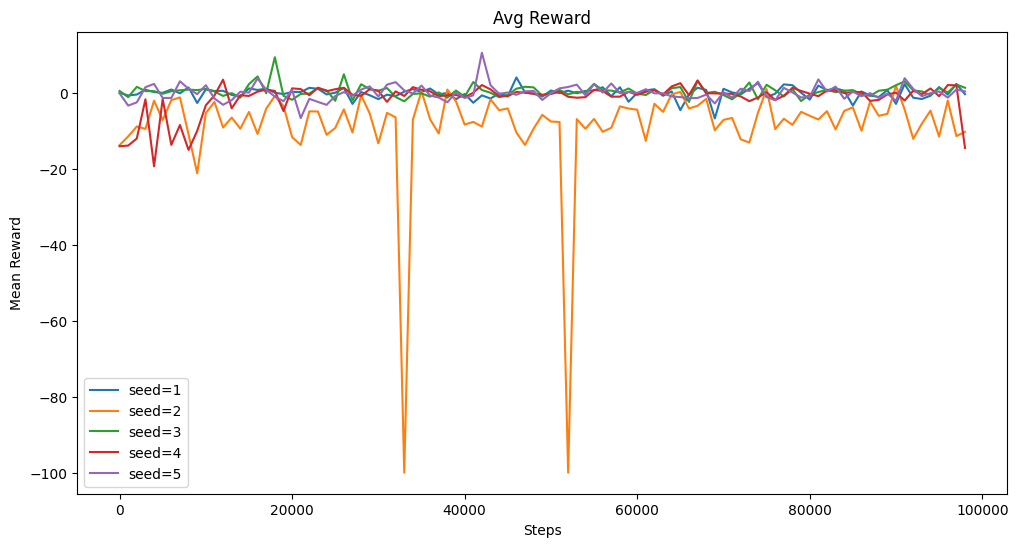

In [276]:
plot_all(training_results_files_stablebaseline)

# Les courbes de l'entrainement avec notre implementation de TD3

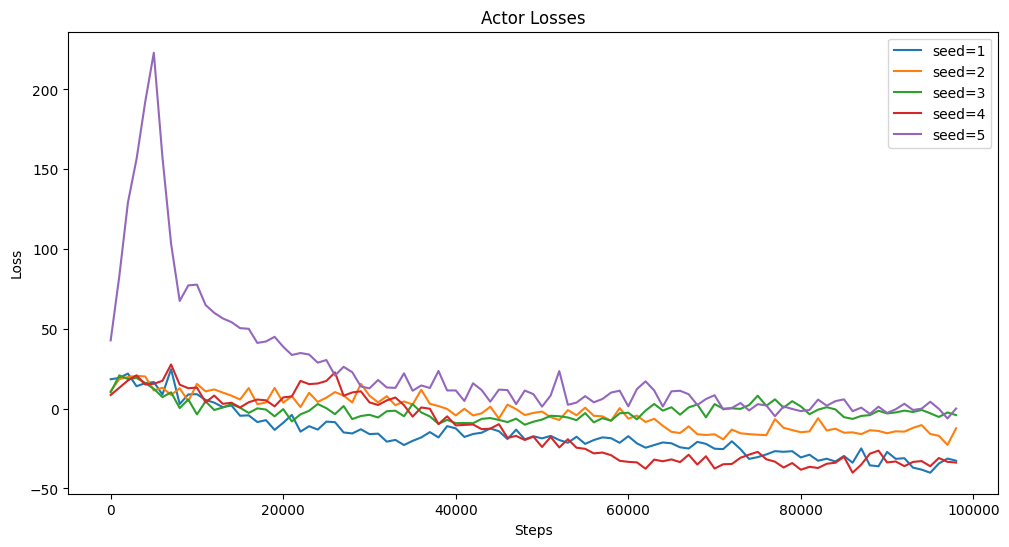

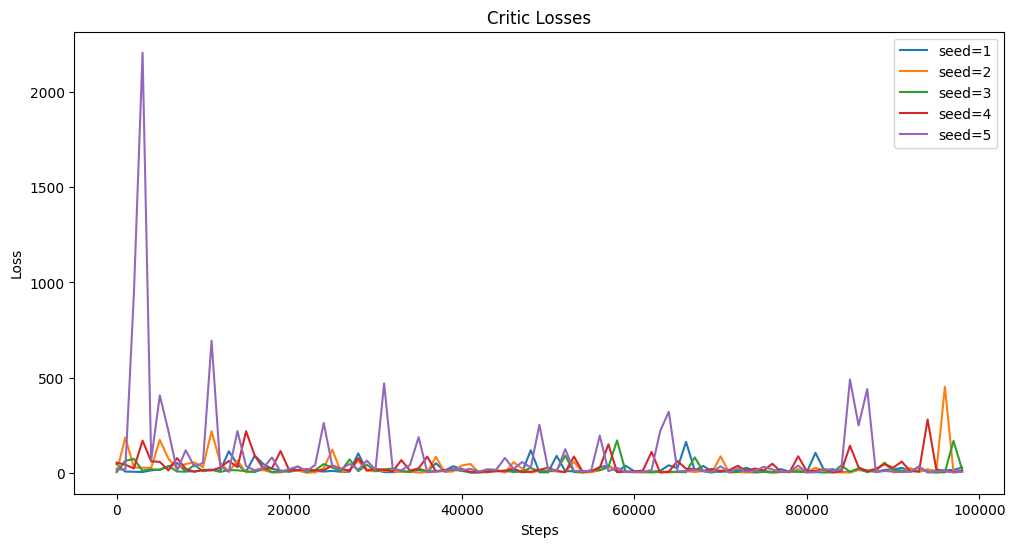

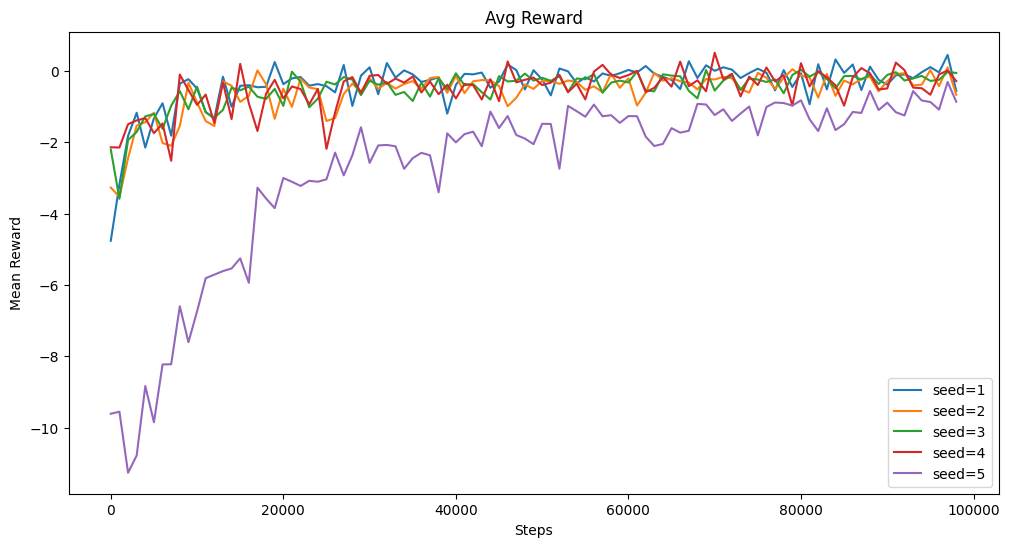

In [277]:
plot_all(training_results_files_implementation)

# Tests statistiques

#### Preparation des données pour les tests (division en une liste par critère)

In [251]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    # plt.savefig(
    #     f"./statistical_tests/{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    # )
    # plt.show()

In [254]:
training_results_files_stablebaseline_critic_losses = np.array([training_results_files_stablebaseline[i]['critic_losses'] for i in range(len(training_results_files_stablebaseline))])
training_results_files_stablebaseline_actor_losses = np.array([training_results_files_stablebaseline[i]['actor_losses'] for i in range(len(training_results_files_stablebaseline))])
training_results_files_stablebaseline_rewards_per_step = np.array([training_results_files_stablebaseline[i]['rewards_per_step'] for i in range(len(training_results_files_stablebaseline))])

In [255]:
training_results_files_implementation_critic_losses = np.array([training_results_files_implementation[i]['critic_losses'] for i in range(len(training_results_files_implementation))])
training_results_files_implementation_actor_losses = np.array([training_results_files_implementation[i]['actor_losses'] for i in range(len(training_results_files_implementation))])
training_results_files_implementation_rewards_per_step = np.array([training_results_files_implementation[i]['rewards_per_step'] for i in range(len(training_results_files_implementation))])

# Transposition avec 

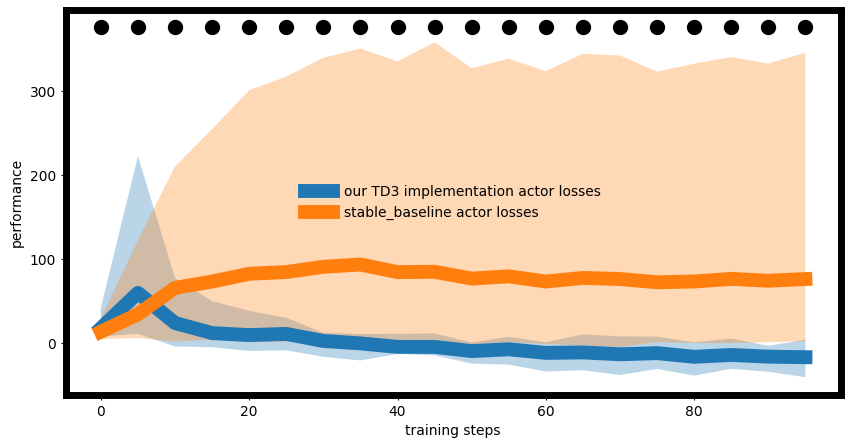

In [258]:
perform_test(
            training_results_files_implementation_actor_losses,
            training_results_files_stablebaseline_actor_losses,
            "our TD3 implementation actor losses",
            "stable_baseline actor losses",
            sample_size=99,  # Taille de l'échantillon à comparer
            downsampling_fact=5,  # Réduction des points à tracer
            confidence_level=0.05  # Niveau de confiance du test
        )

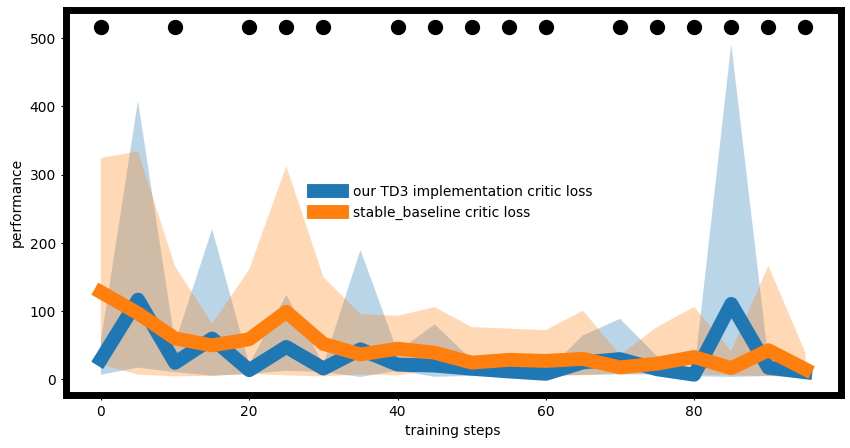

In [259]:
perform_test(
            training_results_files_implementation_critic_losses,
            training_results_files_stablebaseline_critic_losses,
            "our TD3 implementation critic loss",
            "stable_baseline critic loss",
            sample_size=99,  # Taille de l'échantillon à comparer
            downsampling_fact=5,  # Réduction des points à tracer
            confidence_level=0.05  # Niveau de confiance du test
        )

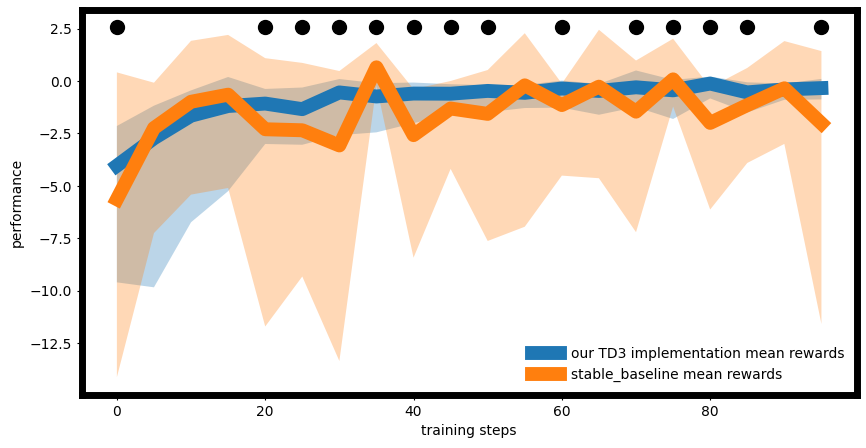

In [261]:
perform_test(
            training_results_files_implementation_rewards_per_step,
            training_results_files_stablebaseline_rewards_per_step,
            "our TD3 implementation mean rewards",
            "stable_baseline mean rewards",
            sample_size=99,  # Taille de l'échantillon à comparer
            downsampling_fact=5,  # Réduction des points à tracer
            confidence_level=0.05  # Niveau de confiance du test
        )